# Load library

In [ ]:
import nltk
nltk.download(['punkt' , 'stopwords'])

In [ ]:
from nltk.tokenize import word_tokenize , sent_tokenize
from nltk.sentiment import SentimentAnalyzer
import pandas as pd
import math
import numpy as np
from tqdm import tqdm
from wordcloud import STOPWORDS
import os
from wordcloud import WordCloud, STOPWORDS
from string import punctuation
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from scipy.linalg import svd
from tqdm import tqdm
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Tải dữ liệu


In [224]:
list_file_name = []
for i in range(1 ,1401 , 1):
    list_file_name.append(str(i) + '.txt')

In [225]:
Cranfield_path = "D:\Python project\SearchNews\Corpus_Cranfield\Cranfield"
data_Cranfield = []
for name in list_file_name:
    with open(os.path.join(Cranfield_path , name), 'r') as file:
              data_Cranfield.append(file.read())

## Tiền xử lý dữ liệu Cranfield
1.   Lọc và chỉ lấy các từ 
2.   Tách từ trong câu
3.   Loại bỏ stopwords 
4.   Sử dụng phương pháp stemma để đưa từ hiện tại về từ gốc của nó

In [226]:
#1 lọc và chỉ lấy các từ
data_Cranfield_word = []
for sample in data_Cranfield:
    temp = []
    for character in sample.split():
        if character.isalpha():
           temp.append(character)
    data_Cranfield_word.append(' '.join(temp))

In [227]:
#2 tách từ trong câu
data_Cranfield_token = [word_tokenize(sample) for sample in data_Cranfield_word]

In [228]:
#lọc stopwords
from nltk.corpus import stopwords
list_english_stopwords = stopwords.words('english')
data_Cranfield_stopwords_token = []
for sample in data_Cranfield_token:
    temp  = []
    for word in sample:
        if word not in list_english_stopwords:
           temp.append(word)
    data_Cranfield_stopwords_token.append(temp)    

In [229]:
#sử dụng EnglishStemmer để đưa từ hiện tại về từ gốc
from nltk.stem.snowball import EnglishStemmer
stemmer = EnglishStemmer()
processed_data_Cranfield_token =[]
for sample in data_Cranfield_stopwords_token:
    temp = []
    for word in sample:
        temp.append(stemmer.stem(word))
    processed_data_Cranfield_token.append(temp)

In [230]:
preprocessed_data_token = processed_data_Cranfield_token

# Vector Space Model


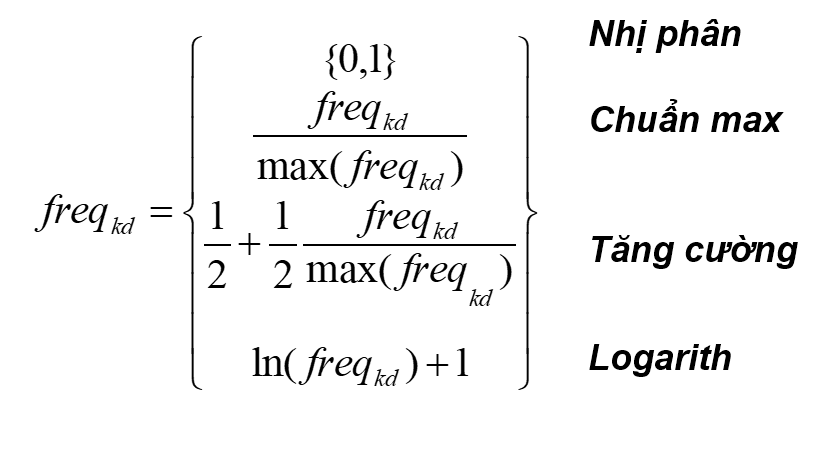

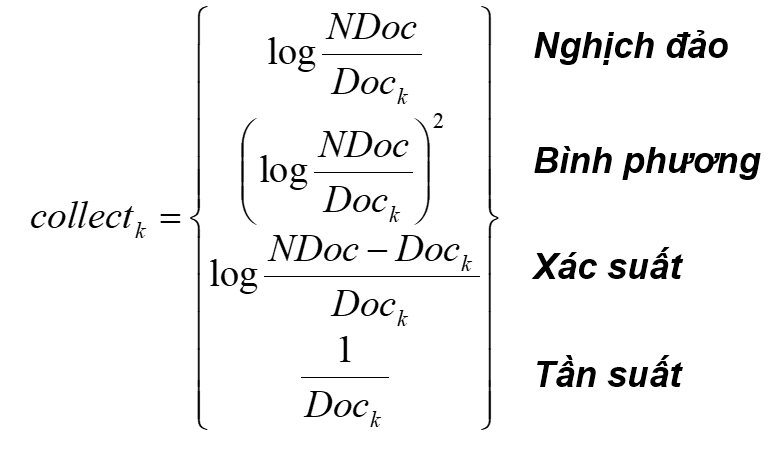

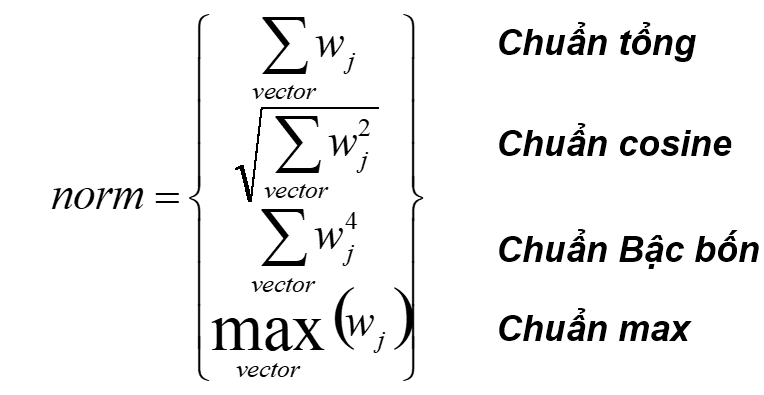

In [444]:
IId={} #từ điển lưu các id document của từng từ , dạng bảng băm
for i in range(len(preprocessed_data_token)):
  check = preprocessed_data_token[i]
  for item in preprocessed_data_token[i]:
    if item in check:
      if item not in IId:
          IId[item]=[]
      if item in IId:
          IId[item].append(i+1)

Tạo bảng từ vựng

In [445]:
vocab=pd.DataFrame(columns=['Key','Frequency']) #tạo bảng từ vựng sau khi tiền xử lý
index=[] # lưu các từ vựng duy nhất
doc_num=[] #tạo list chứa số lượng tài liệu mà k xuất hiện
idf=[] # tạo list lưu idf của từng từ
for item in IId:
  index.append(item)
for i in range(len(index)):
  vocab.loc[i]=[index[i],len(IId[index[i]])] #tính frequency
for i in range(len(IId)):
  docNum=len(set(IId[index[i]]))
  doc_num.append(docNum)
  idf.append(math.log(len(preprocessed_data_token)/docNum))  
vocab.insert(1,"Doc Num", doc_num,True)
vocab.insert(3,"IDF",idf,True)
vocab.set_index("Key", inplace=True)

Posting List

In [446]:
PL={} #Khởi tạo Posting List
count=1
for i in range(len(IId)):
  name=index[i]
  PL[name] = []
  PL[name].append([IId[name][0],1])
  for j in range(1,len(IId[name])):
    if IId[name][j]!=IId[name][j-1]:
      PL[name].append([IId[name][j],1])
    else:
      count=PL[name][-1][-1]
      PL[name][-1].append(count+1)
      PL[name][-1].pop(-2)

TF tính theo cách: tf_{ik} = In(tk_{ik}) + 1

In [447]:
for i in range(len(PL)):
  for j in range(len(PL[index[i]])):
    id=PL[index[i]][j][0]
    term_num_in_doc=PL[index[i]][j][1]
    total_term=len(preprocessed_data_token[id-1])
    PL[index[i]][j].append(term_num_in_doc/total_term)

TFIDF tính theo: $ w_{ik}=tf_{ik}*idf_k$

In [448]:
w=[]
for name in index:
  for i in range(len(PL[name])):
    w.append([PL[name][i][0],PL[name][i][2]*vocab.loc[name]["IDF"]]) #lấy cột IDF của danh sách vocab nhân với cột TF của posting list

Normalize bằng cách chia mỗi weight cho tổng toàn bộ weight trong tài liệu i

Trong Posting list, cột thứ 3 là TF, thứ 4 là weight đã normalized

In [449]:
import itertools
new_list = [(a, list(b)) for a, b in itertools.groupby(sorted(w, key=lambda x:x[0]), key=lambda x:x[0])]#gom nhóm theo id của tài liệu
final_data = [[a, math.sqrt(sum(math.pow(c[1],2) for c in d))] for a, d in new_list] #tính norm dựa trên chuẩn cosin (test: 0.38)
# final_data = [[a, sum(c[1] for c in d)] for a, d in new_list]  # tính norm dựa trên chuẩn tổng (test:0.3648)
# final_data = [[a, sum(math.pow(c[1],4) for c in d)] for a, d in new_list] #tính norm dựa trên chuẩn bậc 4  (test: 0.1416)

In [450]:
new_final_data = {}
for item in final_data:
    new_final_data[item[0]] = item[1]


In [451]:
for i in w:
    i[1] = i[1] /new_final_data[i[0]]

In [452]:
index_of_w=0
for i in range(len(PL)):
  for j in range(len(PL[index[i]])):
    PL[index[i]][j].append(w[index_of_w][1])  # bổ sung cột trọng số của từng term vào danh sách posting list.
    index_of_w = index_of_w + 1

## Query

In [453]:
def unique(list1):
    # insert the list to the set
    list_set = set(list1)
    # convert the set to the list
    unique_list = (list(list_set))
    return unique_list

In [454]:
def query_to_terms(query):#hàm query_to_terms có nhiệm vụ tiền xử lý các câu truy vấn trước khi đưa vào mô hình vector cho việc tìm kiếm
  a = []
  #lọc và chỉ lấy các phần tử là từ
  for sample in query:
      temp = []
      for character in sample.split():
          if character.isalpha():#kiểm tra phần tử có phải là từ hay không ?
            temp.append(character)
      a.append(temp)
  b=[]
  #kiểm tra từ có thuộc stopwords hay không, nếu không phải stopwords thì sử dụng stemmer để đưa từ đó về từ gốc
  for sample in a:
    temp  = []
    for word in sample:
        if word not in list_english_stopwords: #kiểm tra từ đó stopwords hay không ?
          temp.append(stemmer.stem(word)) #sử dụng stemmer để đưa từ về từ gốc
    b.append(temp)
  return b

## Xử lý câu query từ file truy vấn

In [455]:
query = open("D:\Python project\SearchNews\Corpus_Cranfield\query.txt", "r")#đọc tất cả các câu truy vấn từ file query.txt
query = query.read()
query=query.split("\n")#đưa các câu truy vấn thành phần tử của danh sách
for i in range(0, 225):# duyệt qua 255 câu truy vấn
    query[i]=query[i].split("\t") #phân tách giữa id của truy vấn và câu truy vấn dựa vào kí tự "\t"
for i in range(0, 225):
    del query[i][0] #xoá id của truy vấn 
del query[225] 

## Query Processing

In [456]:
"""
Tính trọng số cho từng term của mỗi truy vấn bằng cách lấy TF * IDF.
Trong đó IDF của term được lấy từ danh sách Vocab, TF của term được tính dựa vào câu truy vấn chứa term đó.
"""
for i in range(len(query)):
  query[i]=str(query[i][0]) #chuyển các phần tử trong mảng query sang kiểu str
queries=query_to_terms(query) #xử lý các từ trong mỗi câu truy vấn bằng hàm query_to_terms
unused_term=[] #danh sách các term không có trong tập posting list
for i in range(len(queries)):
 check=queries[i]
 queries[i]=unique(queries[i]) #sử dụng hàm unique để lọc ra term duy nhất trong mỗi truy vấn, từ đó ta có queries mới 
 for j in range(len(queries[i])):#duyệt qua từng queries
   term=queries[i][j] #xác định term
   queries[i][j]=[term] #cập nhật lại 1 mảng lưu term và trọng số của nó Ví dụ: ['smile', 0.746478564]
   try:
     queries[i][j].append((check.count(term)/len(check))*(vocab.loc[term]["IDF"]))
   except KeyError:
     # print(term,"is not a key",i)
     unused_term.append(term)

deleting unused term

In [458]:
#chạy 2 lần phần này
for i in range(len(queries)):
  for j in range(len(queries[i])):
    if len(queries[i])<j:
      break
    else:
      try:
        if queries[i][j][0] in unused_term:
          queries[i].pop(j)
      except:
        continue

Normalizing Weights of Term in Query List

In [459]:
"""
Chuẩn hoá các trọng số của từng term trong mỗi truy vấn sử dụng công thức w_new = w /(w1 + w2 +...+wn) với n là số lượng term của câu truy vấn tương ứng.
"""
for q in queries:
  sum_w=0
  for term in q:
    sum_w += term[1]
  for term in q:
    term[1]=term[1]/sum_w

# LSI model(Lexical Semantic Index)

In [ ]:
import gc
gc.collect()
gc.freeze()

In [ ]:
senti = SentimentAnalyzer()

In [ ]:
all_words_data = senti.all_words(preprocessed_data_token)

In [ ]:
dict_word_frequency_all_docs = nltk.FreqDist(all_words_data)

In [ ]:
list_unique_words = list(dict_word_frequency_all_docs.keys())

In [ ]:
term_doc_dict = {}
for word in list_unique_words:
    term_doc_dict[word] = []
    for i in range(len(preprocessed_data_token)):
        term_doc_dict[word].append([i+1 , preprocessed_data_token[i].count(word)])

In [ ]:
array_freq_word = []
for value in term_doc_dict.values():
       array_freq_word.append(np.array(value)[:,1])

In [ ]:
array_freq_word = np.array(array_freq_word)

## Tính term vector và document vector

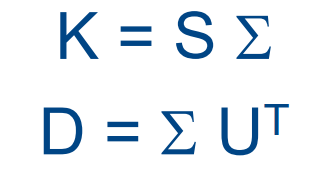

In [ ]:
def SVD_with_k_dimensional(U , Sigma  , VT , K):
     new_Sigma = np.zeros((K , K))
     new_Sigma[:K ,:K] = np.diag(Sigma[:K])
     new_VT = VT[:K]
     new_U = U[:,range(K)]
     term_vector = np.dot(new_U , new_Sigma)
     document_vector = np.dot(new_Sigma , new_VT)
     return term_vector  , document_vector

In [ ]:
U , Sigma , VT = svd(array_freq_word) # sử dụng SVD để tách ma trận doc-term

## Tạo từ điển term_vector và document_term

In [ ]:
def create_dict_term_and_document(term_vector , document_vector):
    dict_term_vector = {}
    for i in range(len(list_unique_words)):
        dict_term_vector[list_unique_words[i]] = term_vector[i]
    dict_document_vector ={}
    for i in range(len(preprocessed_data_token)):
        dict_document_vector[i+1] = document_vector[:,i]
    return dict_term_vector , dict_document_vector

## Query

In [ ]:
query = open("D:\Python project\SearchNews\Corpus_Cranfield\query.txt", "r")#đọc tất cả các câu truy vấn từ file query.txt
query = query.read()
query=query.split("\n")#đưa các câu truy vấn thành phần tử của danh sách
for i in range(0, 225):# duyệt qua 255 câu truy vấn
    query[i]=query[i].split("\t") #phân tách giữa id của truy vấn và câu truy vấn dựa vào kí tự "\t"
for i in range(0, 225):
    del query[i][0] #xoá id của truy vấn 
del query[225] 

## Tiền xử lý câu truy vấn

In [ ]:
def preprocess_text(sent):
    temp_sent = []
    for word in sent.split(): #lọc và chỉ lấy từ 
        if word.isalpha():
            temp_sent.append(word)
    temp_sent = " ".join(temp_sent)
    #tokenize
    temp_sent = word_tokenize(temp_sent) 
    #stopwords
    new_temp_sent  = []
    for i in range(len(temp_sent)):
        if temp_sent[i] not in list_english_stopwords:
               new_temp_sent.append(temp_sent[i])
    #stemmer         
    for i in range(len(new_temp_sent)):
        new_temp_sent[i] = stemmer.stem(new_temp_sent[i])
    return " ".join(new_temp_sent)            

In [ ]:
for i in range(len(query)):
    query[i] =  preprocess_text(query[i][0])

## Query Processing

In [ ]:
def query_processing(dict_term_vector , i):
    sum_vector_query =[]
    for sent in query:
        temp = []
        for word in sent.split():
            try:
                temp.append(dict_term_vector[word])
            except:
                # print("Term is not dict_term_vector")
                # temp.append(np.zeros(i))
                pass
        sum_vector_query.append(np.sum(temp , axis=0, dtype=float)/len(temp))
    return sum_vector_query
            

# Đánh giá 2 mô hình với 225 câu truy vấn trong tập RES

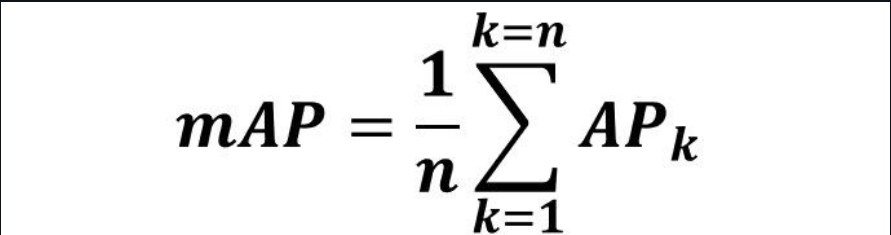

In [215]:
from operator import itemgetter
from scipy.spatial.distance import cosine , euclidean

In [460]:
#Lấy kết quả đúng của đề bài đã cho
response=[]
for i in range (1,226):
  res_file='D:\Python project\SearchNews\Corpus_Cranfield\RES\\'+ str(i) +'.txt'
  with open(res_file, 'r') as f:
      RES=f.readlines()
      for i in range(len(RES)):
        RES[i]=RES[i].replace('\t',' ')
        RES[i]=RES[i].replace('\n','')
      resp=[]
      for i in range(len(RES)):
        resp.append(int(RES[i].split(' ')[1]))
      resp.sort()
      response.append(resp)

In [461]:
real_result = response.copy()

## Vector Space Model

In [462]:
def find_and_add(arr,doc_id,value):
  for i in range(len(arr)):
    if arr[i][0]== doc_id:
         arr[i][1]+=value
  return arr

In [463]:
#tạo danh sách (id_docs ,weight) cho từng truy vấn
predict_result = [] #danh sách lưu kết quả dự đoán tài liệu liên quan của từng truy vấn
for i in range(len(queries)):
  q=queries[i]
  results=[]
  for key in q:
    for j in PL[key[0]]:
      results.append([j[0],j[3]*key[1]])
  doc_rank=[]#lưu trữ (id duy nhất , weight) của từng truy vấn
  check=[]
  for result in results:
    doc_id = result[0]
    if doc_id not in check:
      check.append(doc_id)
      doc_rank.append(result)
    else:
      doc_rank=find_and_add(doc_rank,doc_id,result[1])
  arr=sorted(doc_rank, key=itemgetter(1))#sắp xếp doc_rank theo thứ tự từ bé đến lớn
  predict_result.append(arr[-(len(response[i])):])#lấy số phần tử có  w cao nhất với số lượng bằng với số tài liệu của mỗi truy vấn trong tập RES

In [464]:
#tạo danh sách kết quả mới chỉ lưu các id tài liệu của mỗi truy vấn
new_predict_result_Vector_Space = []
for sample in predict_result:
    temp = []
    for row in sample:
        temp.append(row[0])
    new_predict_result_Vector_Space.append(temp)

## LSI Model


In [ ]:
def predict_result(dict_document_vector , sum_vector_query):
     predict_result = []
     for i in range(len(sum_vector_query)):
          temp = []
          for id , item in dict_document_vector.items():
               temp.append([id , math.dist(sum_vector_query[i] , item)])
          temp.sort(reverse = False , key = itemgetter(1))
          predict_result.append(temp[:len(response[i])])
     new_predict_result_LSI = []
     for sample in predict_result:
          temp = []
          for row in sample:
               temp.append(row[0])
          new_predict_result_LSI.append(temp)
     return new_predict_result_LSI
    

## Sử MAP nội suy cho đánh giá 2 model

In [425]:
def MAP_model(new_predict_result , real_result):
    #tạo danh sách kết quả kiểm tra xem id tài liệu nào có xuất hiện trong tập dự đoán và tập thực tế
    result = []
    for i in range(len(new_predict_result)):
        temp = {}
        for id_docs in new_predict_result[i]:
            if id_docs in real_result[i]:
                temp[id_docs]  = True
            else:
                temp[id_docs] = False
        result.append(temp)
    #tính precision và recall cho từng truy vấn
    precision_recall_queries =[]
    i = 0 
    for sample in result:
        if len(sample) == 0:
            precision_recall_queries.append([])
        else:
            count_appear = 0
            count = 0
            temp = []
            for id_docs , appear in sample.items():
                if appear == False:
                    count +=1
                elif appear == True:
                    count_appear +=1
                    count +=1
                    temp.append([count_appear/count, count_appear/len(real_result[i])])
            precision_recall_queries.append(temp)
        i = i+1  
    #tính AP nội suy cho từng truy vấn
    result_AP_queries  = []
    for sample in precision_recall_queries:
        if len(sample) == 0:
            result_AP_queries.append(0.0)
        else:
            AP = []
            for i in range(len(sample)):
                AP.append(sample[i][0])
            result_AP_queries.append(sum(AP)/len(AP))
    return np.mean(result_AP_queries)

In [465]:
MAP_model(new_predict_result_Vector_Space , real_result)   #vector space model

0.3803495682126866

In [ ]:
MAP_result = [] #LSI model
for i in tqdm(range(2, 201 , 1)):
    term_vector , document_vector = SVD_with_k_dimensional(U , Sigma , VT , i)
    dict_term_vector , dict_document_vector = create_dict_term_and_document(term_vector , document_vector)
    sum_query_vector = query_processing(dict_term_vector , i)
    new_predict_result_LSI = predict_result(dict_document_vector , sum_query_vector)
    MAP_result.append(MAP_model(new_predict_result_LSI, real_result))

In [ ]:
#Show dữ liệu

import matplotlib.pyplot as plt
plt.plot(range(2, 201 , 1) , MAP_result)
plt.show()



In [ ]:
max(MAP_result)